In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/tobigs_NN/'
train_data = pd.read_csv(PATH+'data/train.csv')
test_data = pd.read_csv(PATH+'data/test.csv')
sample_submission = pd.read_csv(PATH+"data/sample_submission.csv")

In [ ]:
# 어떤 자료인지 보자
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X_train = train_data.drop('label',axis = 1).values
y_train = train_data['label'].values

X_test = test_data.iloc[:,1:].values

In [ ]:
X_train.shape, y_train.shape, X_test.shape

((42000, 784), (42000,), (18000, 784))

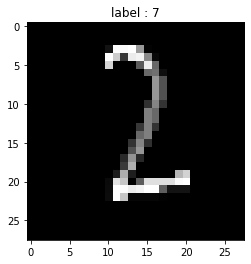

In [ ]:
# 하나 출력해볼까!
index = 0
image = X_train[index].reshape(28,28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

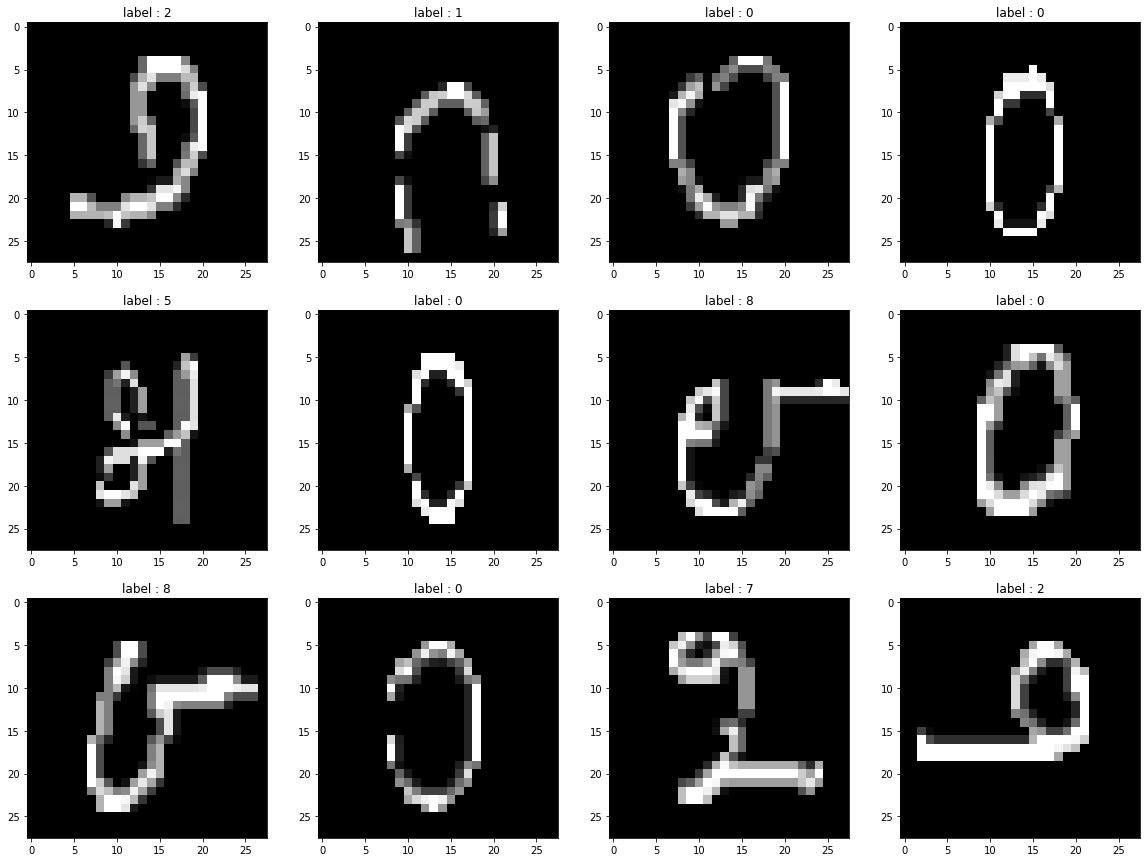

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20,15))
for i in range(3):
    for j in range(4):
        index = np.random.randint(len(y_train))
        image = X_train[index].reshape(28,28)
        axes[i][j].imshow(image, 'gray')
        axes[i][j].set_title('label : {}'.format(y_train[index]))
plt.show()

random하게 12개의 숫자에 대해 그림을 그려보았다.

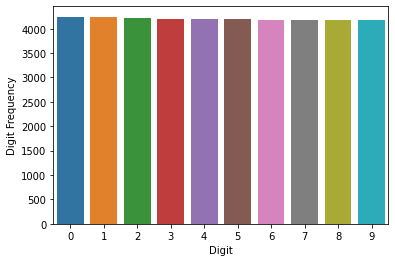

In [ ]:
import seaborn as sns
sns.barplot(x = np.unique(y_train), y = pd.Series(y_train).value_counts())
plt.ylabel('Digit Frequency')
plt.xlabel('Digit')
plt.show()

각 숫자별로 train data는 균등하게 존재한다.

In [ ]:
# 전체 784 pixel, 즉, 28*28 사이즈의 그림들임!

image_size = X_train.shape[1]
print ('image_size => {0}'.format(image_size))

# in this case all images are square
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

print ('image_width => {0}\nimage_height => {1}'.format(image_width,image_height))

image_size => 784
image_width => 28
image_height => 28


In [ ]:
# scaling

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

print('maximum value after scaling:', X_train.max(),
      '\nminimum value after scaling:' ,X_train.min())

maximum value after scaling: 1.0 
minimum value after scaling: 0.0


In [ ]:
# train test split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(33600, 784) (33600,)
(8400, 784) (8400,)


## 0. Baseline: tensorflow keras model

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2), 
    # dropout 대신 keras.layers.BatchNormalization() 이용 가능
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=5, batch_size=100)
model.evaluate(X_val, y_val)

Epoch 1/5
336/336 [==============================] - 1s 2ms/step - loss: 0.4389 - accuracy: 0.8745
Epoch 2/5
336/336 [==============================] - 1s 2ms/step - loss: 0.0765 - accuracy: 0.9767
Epoch 3/5
336/336 [==============================] - 1s 2ms/step - loss: 0.0430 - accuracy: 0.9865
Epoch 4/5
336/336 [==============================] - 1s 2ms/step - loss: 0.0303 - accuracy: 0.9908
Epoch 5/5
263/263 [==============================] - 1s 2ms/step - loss: 0.0609 - accuracy: 0.9827


[0.06091656908392906, 0.9827380776405334]

In [ ]:
predictions = model.predict_classes(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [ ]:
sample_submission.to_csv("submission.csv",index=False)

## 1. Batch Normalization 추가
Batch Normalizationdml 위치는 Activation 전으로 두고, Dropout layer는 Activation layer 뒤에 두었다.

In [ ]:
X_train1, X_val1, y_train1, y_val1 = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
model = keras.Sequential([
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dropout(0.2), 
    # dropout 대신 keras.layers.BatchNormalization() 이용 가능
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train1, y_train1, epochs=10, batch_size=100, validation_data = (X_val1, y_val1))
model.evaluate(X_val, y_val)

Epoch 1/10
269/269 [==============================] - 2s 5ms/step - loss: 0.5109 - accuracy: 0.8503 - val_loss: 0.1086 - val_accuracy: 0.9731
Epoch 2/10
269/269 [==============================] - 1s 4ms/step - loss: 0.1038 - accuracy: 0.9715 - val_loss: 0.0791 - val_accuracy: 0.9772
Epoch 3/10
269/269 [==============================] - 1s 4ms/step - loss: 0.0657 - accuracy: 0.9805 - val_loss: 0.0619 - val_accuracy: 0.9830
Epoch 4/10
269/269 [==============================] - 1s 4ms/step - loss: 0.0445 - accuracy: 0.9876 - val_loss: 0.0539 - val_accuracy: 0.9838
Epoch 5/10
269/269 [==============================] - 1s 4ms/step - loss: 0.0359 - accuracy: 0.9900 - val_loss: 0.0577 - val_accuracy: 0.9830
Epoch 6/10
269/269 [==============================] - 1s 4ms/step - loss: 0.0283 - accuracy: 0.9912 - val_loss: 0.0486 - val_accuracy: 0.9851
Epoch 7/10
269/269 [==============================] - 1s 4ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.0531 - val_accuracy: 0.9847
Epoch 

[0.053921688348054886, 0.9846428632736206]

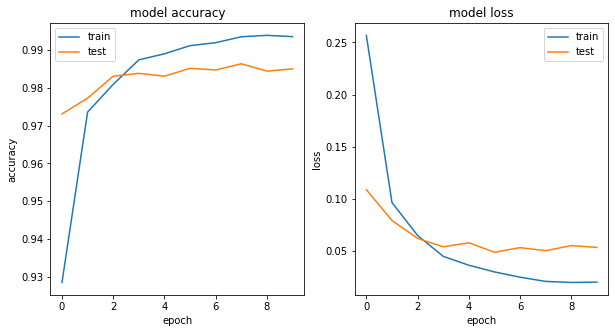

In [ ]:
def make_plot(history):
    fig, axes = plt.subplots(ncols=2, figsize=(10,5))
    axes[0].plot(history.history['accuracy'])
    axes[0].plot(history.history['val_accuracy'])
    axes[0].set_title('model accuracy')
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'test'], loc='upper left')
    axes[1].plot(history.history['loss'])
    axes[1].plot(history.history['val_loss'])
    axes[1].set_title('model loss')
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'test'], loc='upper right')
    plt.show()
make_plot(history)

In [ ]:
predictions = model.predict_classes(X_test)
sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [ ]:
sample_submission.to_csv(PATH+"submission/submission_bn.csv",index=False)

제출 결과는 **0.98433**이다.

## 2. Transfer Learning
이미 학습이 되어있는 모델을 이용하여 새로운 데이터셋에 대해 fine tuning을 시행하였다. base model은 MobileNetV2를 사용하였다. 

In [ ]:
from keras.callbacks import LearningRateScheduler, EarlyStopping

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
earlystop = EarlyStopping(patience = 15, monitor = 'val_loss')

epoch이 지남에 따라 learning rate를 줄여 수렴을 도와주는 learning rate scheduler와 loss가 더이상 줄지 않으면 조기중단을 하는 early stopping을 추가하였다.

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_size(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    img = img.resize((32, 32)) #resize image
    img = img.convert(mode='RGB') #makes 3 channels
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

X_trainRGB = [change_size(img) for img in X_train.reshape(-1,28,28,1)]
X_trainRGB = np.array(X_trainRGB)
print("X_train RGB: {}".format(X_trainRGB.shape))

X_train2, X_val2, y_train2, y_val2 = train_test_split(X_trainRGB, y_train, test_size=0.2, random_state=42)

X_train RGB: (33600, 32, 32, 3)


대부분의 pre-trained model은 imagenet을 dataset으로 사용했다. 우리의 데이터셋은 흑백이기 때문에 model의 input에 알맞게 RGB채널로 바꿔줘야 한다.

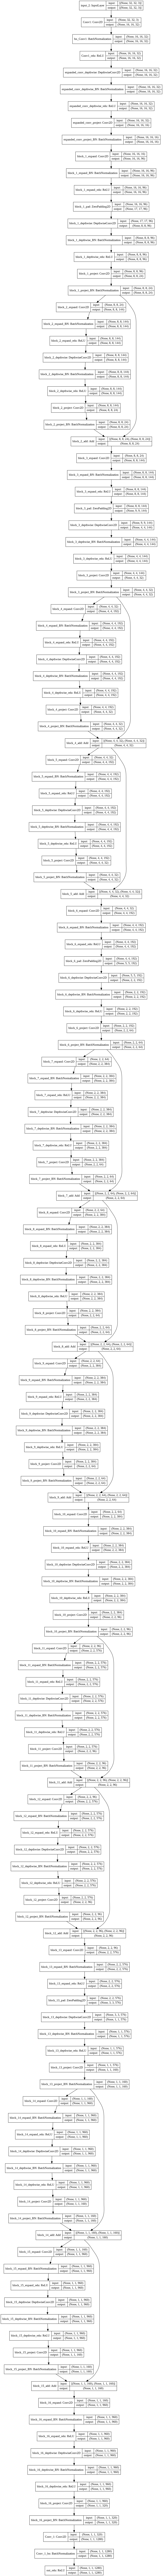

In [ ]:
from tensorflow.keras.utils import plot_model

base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
plot_model(base_model, show_shapes=True)

MobileNetV2는 성능하락을 최소화하는 동시에 경량화한 모델이다. stride가 1인 residual block이고 두번째는 downsizing을 위한 stride가 2인 block으로 구성되었다. 모델의 크기는 14MB임에도 불구하고 imagenet의 top-1 accuracy는 약 72%로 높은 축에 속한다.

Epoch 1/100
105/105 [==============================] - 8s 42ms/step - loss: 0.4959 - accuracy: 0.8589 - val_loss: 0.4022 - val_accuracy: 0.8844
Epoch 2/100
105/105 [==============================] - 4s 35ms/step - loss: 0.1747 - accuracy: 0.9402 - val_loss: 0.3216 - val_accuracy: 0.8967
Epoch 3/100
105/105 [==============================] - 4s 35ms/step - loss: 0.1554 - accuracy: 0.9451 - val_loss: 0.4108 - val_accuracy: 0.8766
Epoch 4/100
105/105 [==============================] - 4s 35ms/step - loss: 0.1363 - accuracy: 0.9527 - val_loss: 0.4607 - val_accuracy: 0.8708
Epoch 5/100
105/105 [==============================] - 4s 35ms/step - loss: 0.1299 - accuracy: 0.9545 - val_loss: 0.4816 - val_accuracy: 0.8705
Epoch 6/100
105/105 [==============================] - 4s 35ms/step - loss: 0.1210 - accuracy: 0.9582 - val_loss: 0.4800 - val_accuracy: 0.8717
Epoch 7/100
105/105 [==============================] - 4s 35ms/step - loss: 0.1102 - accuracy: 0.9633 - val_loss: 0.4275 - val_accuracy:

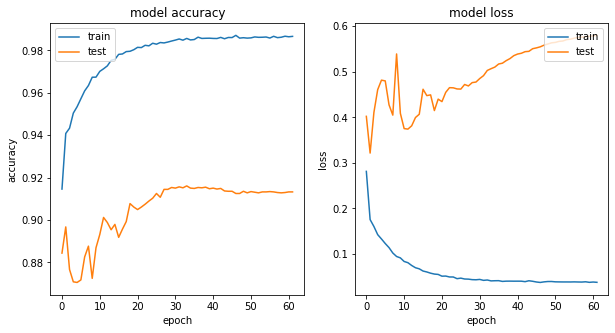

In [ ]:
model = keras.Sequential([
    base_model,       # pre-trained model을 쌓는다.
    keras.layers.Flatten(), #마지막 shape가 (1,1,1280)이므로 fully connected layer를 붙이기 위해 1차원으로 펴는 flatten layer를 추가한다.
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax') # 최종적으로 10개의 class로 분류한다.
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train2, y_train2, epochs=100, batch_size=256, validation_data = (X_val2, y_val2), callbacks=[annealer, earlystop])
make_plot(history)

In [ ]:
X_valRGB = [change_size(img) for img in X_val.reshape(-1,28,28,1)]
X_valRGB = np.array(X_valRGB)
model.evaluate(X_valRGB, y_val)

263/263 [==============================] - 2s 8ms/step - loss: 0.6253 - accuracy: 0.9110


[0.6253340244293213, 0.9109523892402649]

validation 성능이 오히려 하락하였다. 데이터에 비해 모델이 너무 복잡해서 overfitting이 발생하는 것으로 추측된다. 

## 3. Data Augmentation
모델에 비해 데이터가 적은 감이 있어서 robustness를 향상하기 위해 data augmentation을 실시하였다. ImageDataGenerator를 이용하여 확대 범위는 [0.9, 1.1], 좌우 이동은 0.2, 상하 이동은 0.2로 설정하였다.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


image_gen = ImageDataGenerator(zoom_range=0.1,
                              width_shift_range=0.2,
                              height_shift_range=0.2,
                              validation_split=0.2) # 80/20 train/val split


train_generator = image_gen.flow(X_trainRGB, y_train, batch_size=256, shuffle=True, subset='training', seed=42)
valid_generator = image_gen.flow(X_trainRGB, y_train, batch_size=256, shuffle=True, subset='validation')

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs=10, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size, callbacks = [annealer, earlystop])

Epoch 1/10
105/105 [==============================] - 19s 148ms/step - loss: 1.0356 - accuracy: 0.7662 - val_loss: 1.2057 - val_accuracy: 0.7225
Epoch 2/10
105/105 [==============================] - 15s 141ms/step - loss: 0.5004 - accuracy: 0.8342 - val_loss: 0.9533 - val_accuracy: 0.7535
Epoch 3/10
105/105 [==============================] - 15s 141ms/step - loss: 0.4565 - accuracy: 0.8465 - val_loss: 0.8251 - val_accuracy: 0.7736
Epoch 4/10
105/105 [==============================] - 15s 141ms/step - loss: 0.4637 - accuracy: 0.8433 - val_loss: 0.8689 - val_accuracy: 0.7569
Epoch 5/10
105/105 [==============================] - 15s 142ms/step - loss: 0.4346 - accuracy: 0.8540 - val_loss: 0.6415 - val_accuracy: 0.7955
Epoch 6/10
105/105 [==============================] - 15s 145ms/step - loss: 0.4199 - accuracy: 0.8553 - val_loss: 0.6714 - val_accuracy: 0.7820
Epoch 7/10
105/105 [==============================] - 15s 145ms/step - loss: 0.4146 - accuracy: 0.8576 - val_loss: 0.6115 - val_ac

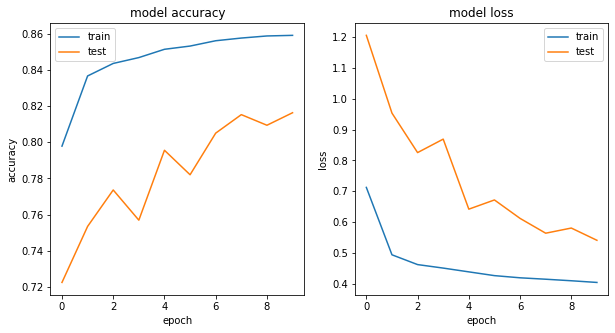

263/263 [==============================] - 3s 8ms/step - loss: 0.4616 - accuracy: 0.8404
[0.4615952670574188, 0.8403571248054504]


In [ ]:
make_plot(history)
X_valRGB = [change_size(img) for img in X_val.reshape(-1,28,28,1)]
X_valRGB = np.array(X_valRGB)
print(model.evaluate(X_valRGB, y_val))

성능이 더 하락한 것을 확인할 수 있다. 데이터의 양이 충분히 증가하였음에도 불구하고 여전히 성능이 개선되지 않는 것으로 보아, Imagenet으로 pre-trained된 base model을 사용하는 것이 문제로 추측된다. Kannada MNIST는 Imagenet과 달리 흑백 사진이며, 숫자에 대한 정보만을 담고 있기 때문에 transfer learning이 무의미한 것으로 추측된다.

## 4. Data Augmentation with Baseline

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def change_2D(image):
    img = array_to_img(image, scale=False) #returns PIL Image
    arr = img_to_array(img) #convert back to array
    return arr.astype(np.float64)

X_train_ = [change_2D(img) for img in X_train.reshape(-1,28,28,1)]
X_train_ = np.array(X_train_)
print("X_train RGB: {}".format(X_train_.shape))

X_train RGB: (33600, 28, 28, 1)


In [ ]:
image_gen = ImageDataGenerator(zoom_range=0.1,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              rotation_range = 10, 
                              validation_split=0.2) # 80/20 train/val split


train_generator = image_gen.flow(X_train_, y_train, batch_size=256, shuffle=True, subset='training', seed=42)
valid_generator = image_gen.flow(X_train_, y_train, batch_size=256, shuffle=True, subset='validation')

In [ ]:
model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.2), 
    # dropout 대신 keras.layers.BatchNormalization() 이용 가능
    keras.layers.Dense(10, activation='softmax')
])


model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator, validation_data=valid_generator, epochs=50, 
          steps_per_epoch=train_generator.n//train_generator.batch_size,
         validation_steps=valid_generator.n//valid_generator.batch_size, callbacks = [annealer, earlystop])

Epoch 1/50
105/105 [==============================] - 8s 71ms/step - loss: 1.6128 - accuracy: 0.4584 - val_loss: 0.9000 - val_accuracy: 0.7025
Epoch 2/50
105/105 [==============================] - 7s 71ms/step - loss: 0.8891 - accuracy: 0.7022 - val_loss: 0.7295 - val_accuracy: 0.7601
Epoch 3/50
105/105 [==============================] - 7s 69ms/step - loss: 0.7455 - accuracy: 0.7469 - val_loss: 0.6538 - val_accuracy: 0.7770
Epoch 4/50
105/105 [==============================] - 7s 69ms/step - loss: 0.6911 - accuracy: 0.7605 - val_loss: 0.6117 - val_accuracy: 0.7942
Epoch 5/50
105/105 [==============================] - 7s 70ms/step - loss: 0.6500 - accuracy: 0.7803 - val_loss: 0.6009 - val_accuracy: 0.8003
Epoch 6/50
105/105 [==============================] - 7s 71ms/step - loss: 0.6025 - accuracy: 0.7928 - val_loss: 0.5663 - val_accuracy: 0.8116
Epoch 7/50
105/105 [==============================] - 7s 69ms/step - loss: 0.5928 - accuracy: 0.7914 - val_loss: 0.5490 - val_accuracy: 0.8104

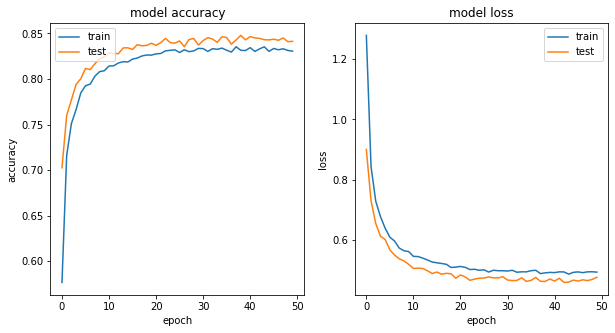

263/263 [==============================] - 1s 2ms/step - loss: 0.3504 - accuracy: 0.8813
[0.35043230652809143, 0.8813095092773438]


In [ ]:
X_val_ = [change_2D(img) for img in X_val.reshape(-1,28,28,1)]
X_val_ = np.array(X_val_)
make_plot(history)
print(model.evaluate(X_val_, y_val))

baseline과 동일한 모델을 사용했음에도 불구하고, data augmentation을 한 결과, 성능이 하락하였다. 정확한 원인은 모르겠지만 data augmentation을 하면서 특정 이미지들로 overfitting되어 오히려 성능이 하락한 것으로 추측된다.
## 5. Back to the Baseline + 1 layer
baseline model에 Fully Connected Layer를 하나 추가한 후, Data Augmentation 없이 학습을 진행하였다.


In [ ]:
model = keras.Sequential([
    keras.layers.Dense(512),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(256),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(64),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('relu'),
    keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train1, y_train1, epochs=100, batch_size=128, validation_data = (X_val1, y_val1), callbacks = [annealer, earlystop])

Epoch 1/100
210/210 [==============================] - 2s 4ms/step - loss: 0.4727 - accuracy: 0.8761 - val_loss: 0.1401 - val_accuracy: 0.9746
Epoch 2/100
210/210 [==============================] - 1s 3ms/step - loss: 0.0531 - accuracy: 0.9876 - val_loss: 0.0830 - val_accuracy: 0.9762
Epoch 3/100
210/210 [==============================] - 1s 3ms/step - loss: 0.0247 - accuracy: 0.9941 - val_loss: 0.0548 - val_accuracy: 0.9842
Epoch 4/100
210/210 [==============================] - 1s 3ms/step - loss: 0.0134 - accuracy: 0.9975 - val_loss: 0.0610 - val_accuracy: 0.9842
Epoch 5/100
210/210 [==============================] - 1s 3ms/step - loss: 0.0093 - accuracy: 0.9984 - val_loss: 0.0537 - val_accuracy: 0.9860
Epoch 6/100
210/210 [==============================] - 1s 3ms/step - loss: 0.0044 - accuracy: 0.9997 - val_loss: 0.0624 - val_accuracy: 0.9841
Epoch 7/100
210/210 [==============================] - 1s 3ms/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.0523 - val_accuracy: 0.9854

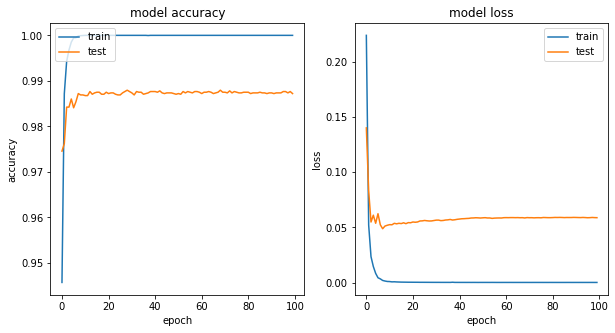

263/263 [==============================] - 0s 2ms/step - loss: 0.0633 - accuracy: 0.9875


[0.063328318297863, 0.987500011920929]

In [ ]:
make_plot(history)
model.evaluate(X_val, y_val)

In [ ]:
predictions = model.predict_classes(X_test)
sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [ ]:
sample_submission.to_csv(PATH+"submission/submission_bn_nodropout_+1layer.csv", index=False)

Testset의 accuracy는 0.98716으로 기존보다 조금 더 나아진 결과를 얻을 수 있었다.
## 6. Pre-trained by MNIST

In [ ]:
import tensorflow as tf
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data()

X_mnist_train = X_mnist_train.reshape(-1, 28, 28, 1)
X_mnist_test = X_mnist_test.reshape(-1, 28, 28, 1)
 
X_mnist_train = X_mnist_train.astype('float32') / 255.
X_mnist_test = X_mnist_test.astype('float32') / 255.
X_mnist_train, X_mnist_val, y_mnist_train, y_mnist_val = train_test_split(X_mnist_train, y_mnist_train, test_size=0.2, random_state=42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(64, (2,2), padding= 'same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (2,2), padding= 'same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (2,2), padding= 'same'),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation = 'softmax')

])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_mnist_train, y_mnist_train, epochs=50, batch_size=128, validation_data = (X_mnist_val, y_mnist_val), callbacks=[annealer, earlystop])

Epoch 1/50
375/375 [==============================] - 4s 8ms/step - loss: 0.7974 - accuracy: 0.7339 - val_loss: 0.1019 - val_accuracy: 0.9692
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1427 - accuracy: 0.9554 - val_loss: 0.0635 - val_accuracy: 0.9818
Epoch 3/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1054 - accuracy: 0.9677 - val_loss: 0.0520 - val_accuracy: 0.9840
Epoch 4/50
375/375 [==============================] - 3s 8ms/step - loss: 0.0830 - accuracy: 0.9736 - val_loss: 0.0459 - val_accuracy: 0.9872
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 0.0702 - accuracy: 0.9788 - val_loss: 0.0439 - val_accuracy: 0.9872
Epoch 6/50
375/375 [==============================] - 3s 8ms/step - loss: 0.0639 - accuracy: 0.9807 - val_loss: 0.0388 - val_accuracy: 0.9887
Epoch 7/50
375/375 [==============================] - 3s 8ms/step - loss: 0.0590 - accuracy: 0.9822 - val_loss: 0.0367 - val_accuracy: 0.9898
Epoch 

313/313 [==============================] - 1s 3ms/step - loss: 0.0243 - accuracy: 0.9920
[0.02432156912982464, 0.9919999837875366]


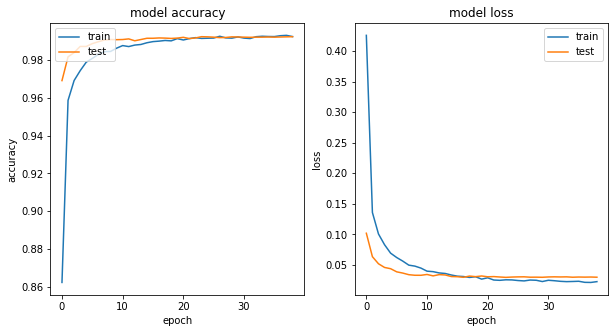

In [ ]:
print(model.evaluate(X_mnist_test, y_mnist_test))
make_plot(history)

기본 MNIST에 대해 약 99.2%의 성능을 보이는 모델을 미리 학습시켰다. 이 모델을 Kannada digits에 대해 fine tuning을 진행하였다.

In [ ]:
# 기존의 데이터들을 2D형태로 reshape한다.
X_train_2D = X_train.reshape(-1, 28, 28, 1)
X_val_2D = X_val.reshape(-1, 28, 28, 1)
X_train_2D1, X_train_2D2, y_train1, y_train2 = train_test_split(X_train_2D, y_train, test_size=0.2, random_state=42)

In [ ]:
model.Trainable = False # model이 학습되지 않도록 freeze한다.
model.layers

In [ ]:
model.layers[-1].Trainable = True
model.layers[-3].Trainable = True

기존의 모델에서 Fully Connected Layer부분 만을 새로 학습시켜준다.

In [ ]:
history = model.fit(X_train_2D1, y_train1, epochs=50, batch_size=128, validation_data = (X_train_2D2, y_train2), callbacks=[annealer, earlystop])

Epoch 1/50
210/210 [==============================] - 2s 9ms/step - loss: 0.3568 - accuracy: 0.9022 - val_loss: 0.0501 - val_accuracy: 0.9857
Epoch 2/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0899 - accuracy: 0.9729 - val_loss: 0.0328 - val_accuracy: 0.9918
Epoch 3/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0650 - accuracy: 0.9797 - val_loss: 0.0282 - val_accuracy: 0.9924
Epoch 4/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0536 - accuracy: 0.9836 - val_loss: 0.0255 - val_accuracy: 0.9935
Epoch 5/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0477 - accuracy: 0.9851 - val_loss: 0.0241 - val_accuracy: 0.9945
Epoch 6/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0433 - accuracy: 0.9871 - val_loss: 0.0225 - val_accuracy: 0.9937
Epoch 7/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0354 - accuracy: 0.9891 - val_loss: 0.0251 - val_accuracy: 0.9926
Epoch 

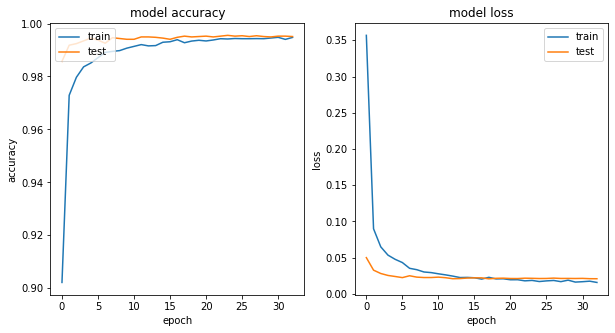

263/263 [==============================] - 1s 3ms/step - loss: 0.0251 - accuracy: 0.9937


[0.02512650191783905, 0.9936904907226562]

In [ ]:
make_plot(history)
model.evaluate(X_val_2D, y_val)

In [ ]:
predictions = model.predict_classes(X_test.reshape(-1, 28, 28, 1))
sample_submission['Category'] = pd.Series(predictions)
sample_submission.head()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


In [ ]:
sample_submission.to_csv(PATH+"submission/submission_transfer.csv",index=False)

Testset Accuracy가 0.99461로 높은 성능을 보여주었다.
## Extra) Transfer Learning without Freezing
CNN layer들도 training이 가능하도록 freezing을 하지 않고, 학습을 진행하였다.

Epoch 1/50
210/210 [==============================] - 2s 9ms/step - loss: 0.0254 - accuracy: 0.9916 - val_loss: 0.0227 - val_accuracy: 0.9943
Epoch 2/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0264 - accuracy: 0.9913 - val_loss: 0.0212 - val_accuracy: 0.9945
Epoch 3/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0238 - accuracy: 0.9920 - val_loss: 0.0215 - val_accuracy: 0.9954
Epoch 4/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0207 - accuracy: 0.9932 - val_loss: 0.0251 - val_accuracy: 0.9943
Epoch 5/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.0234 - val_accuracy: 0.9943
Epoch 6/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.0223 - val_accuracy: 0.9949
Epoch 7/50
210/210 [==============================] - 2s 8ms/step - loss: 0.0157 - accuracy: 0.9947 - val_loss: 0.0213 - val_accuracy: 0.9952
Epoch 

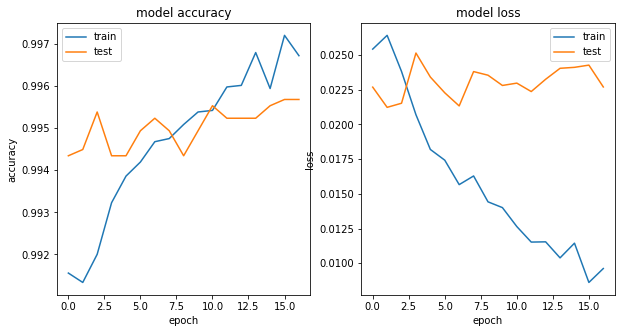

263/263 [==============================] - 1s 3ms/step - loss: 0.0254 - accuracy: 0.9949
[0.02543863281607628, 0.9948809742927551]


In [ ]:
model.Trainable = True
history = model.fit(X_train_2D1, y_train1, epochs=50, batch_size=128, validation_data = (X_train_2D2, y_train2), callbacks=[annealer, earlystop])
make_plot(history)
print(model.evaluate(X_val_2D, y_val))

In [ ]:
predictions = model.predict_classes(X_test.reshape(-1, 28, 28, 1))
sample_submission['Category'] = pd.Series(predictions)
sample_submission.to_csv(PATH+"submission/submission_transfer_woFreeze.csv",index=False)
sample_submission.head()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Id,Category
0,57808,8
1,4960,0
2,35755,5
3,15543,3
4,48968,8


성능이 소폭이지만 향상하는 것을 확인할 수 있었다. Test Accuracy는 0.995로 가장 높은 성능을 기록하였다.